<a href="https://colab.research.google.com/github/Catolampus/Fruit_detection/blob/master/Fruit_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Фреймворк - Pytorch (torchvision.models.detection)

2)Запуск детектора на случайных картинках


In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision as tv
from PIL import Image
import cv2
from pathlib import Path
from xml.etree import ElementTree
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


--2020-07-17 12:01:31--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227231 (222K) [image/jpeg]
Saving to: ‘800px-Apples.jpg’

800px-Apples.jpg    100%[===================>] 221.91K  1.11MB/s    in 0.2s    

2020-07-17 12:01:31 (1.11 MB/s) - ‘800px-Apples.jpg’ saved [227231/227231]



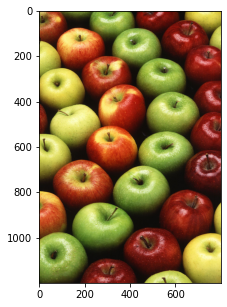

In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
pilimg = Image.open('/content/800px-Apples.jpg')
plt.figure(figsize=(10,5))
plt.imshow(pilimg);

In [4]:
model.eval()
img = tv.transforms.ToTensor()(pilimg).unsqueeze(0)
predict = model(img)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [5]:
def plot_preds(pilimg, predict):
    numimg = np.array(pilimg)
    boxes = predict[0]['boxes'][predict[0]['scores']>0.8].cpu().detach().numpy()
    labels = predict[0]['labels'][predict[0]['scores']>0.8].cpu().detach().numpy()
    # Переведем метки в названия
    COCO = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    # Отрисовка
    counter=0
    for i in boxes:
        final = cv2.rectangle(numimg, (i[0],i[1]), (i[2],i[3]), color=(128, 0, 128), thickness=3)
        cv2.putText(numimg, str(COCO[labels[counter]]), (i[0],i[1]), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (0,0,0), 2)
        counter+=1
    plt.figure(figsize=(10,5))
    return plt.imshow(final)

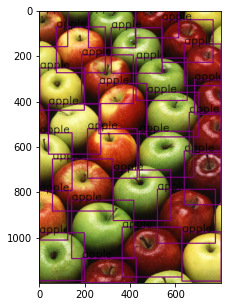

In [6]:
plot_preds(pilimg, predict)

В данном проекте попытаюсь выполнить оба сценария.
Датасет: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection
Детекция фруктов

In [7]:
#Загрузим датасет
import gdown
gdown.download('https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM', '34662_46346_bundle_archive.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM
To: /content/34662_46346_bundle_archive.zip
29.7MB [00:00, 209MB/s]


'34662_46346_bundle_archive.zip'

In [8]:
#Разархивируем датасет с каггла
!unzip -q 34662_46346_bundle_archive.zip

In [6]:
#Кодируем классы
label_code = ['__background__', 'apple', 'orange', 'banana']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
#Меняем количество классов для предсказания
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

In [11]:
class FrutDataset (torch.utils.data.Dataset):
    def __init__(self, path, mode):
        self.path = path 
        self.mode = mode
        path = Path(path)
        if mode == "train":
            _path = path /'train_zip'/'train'
            self.img_lst = list(sorted(_path.glob("*.jpg")))
            self.xml_lst = list(sorted(_path.glob("*.xml")))
        elif mode == "test":
            _path = path/'test_zip'/'test'
            self.img_lst = list(sorted(_path.glob("*.jpg")))
            self.xml_lst = list(sorted(_path.glob("*.xml")))
        else:
            raise ValueError('Incorrect mode')
    
    def __len__(self):
        return len(self.img_lst)

    def __getitem__(self, index):
        img = self.img_lst[index]
        label = self.xml_lst[index]
        pil = Image.open(img).convert('RGB')
        if self.mode == "train":
            #Трансофрмации
            rndlist = [tv.transforms.ColorJitter(brightness=(0, 1),
                                                 contrast=(0, 1),
                                                 saturation=(0, 1))]
                                                 #tv.transforms.RandomGrayscale(p=0.3)
            transform = tv.transforms.Compose([
                                            tv.transforms.RandomChoice(rndlist),
                                            tv.transforms.ToTensor()])
            x = transform(pil)
        else:
            x = tv.transforms.ToTensor()(pil)
        #Извлечем координаты из xml
        tr = ElementTree.parse(label)
        root = tr.getroot()
        name = []
        coord = []
        labels_code = ['__background__','apple', 'orange', 'banana']
        for element in root.iter('object'):
            tempcoord = []
            for child in element:
                if child.tag == 'name':
                    name += [labels_code.index(child.text)]
                elif child.tag == 'bndbox':
                    for i in child:
                        tempcoord +=[int(i.text)]
                    coord +=[tempcoord]
        coord = torch.LongTensor(coord)
        name = torch.LongTensor(name)
        label = {'boxes':coord , 'labels': name}
        return (x, label)

In [12]:
#Создаем обучающий и валидационный сеты
train_set = FrutDataset(path = '/content', mode='train')
val_set = FrutDataset(path = '/content', mode='test')

In [13]:
def my_collate(batch):
    image = [i[0].to(device) for i in batch]
    target = [i[1] for i in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return image, target

In [14]:
#Загрузчики
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           shuffle=True, collate_fn=my_collate)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, 
                                         shuffle=False, collate_fn=my_collate)

In [15]:
optim = torch.optim.AdamW(model.parameters(), amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)

In [16]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [17]:
def train_one_epoch(model, optimizer, train_set):
    model.train()
    save_loss = 0
    for images, targets in train_set:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        save_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'loss for {epoch} epoch {save_loss}')
    return save_loss

In [18]:
def iou (box_true, box_pred):
    '''
    box_true - [x1,y1,x2,y2]
    box_pred - [x1,y1,x2,y2]
    '''
    x1i = max(box_true[0],box_pred[0])
    y1i = max(box_true[1],box_pred[1])
    x2i = min(box_true[2],box_pred[2])
    y2i = min(box_true[3],box_pred[3])
    intersection = abs(y2i-y1i)*abs(x2i-x1i)
    box_true_area = (box_true[2]-box_true[0])*(box_true[3]-box_true[1])
    box_pred_area = (box_pred[2]-box_pred[0])*(box_pred[3]-box_pred[1])
    union = box_true_area+box_pred_area-intersection
    iou = intersection/(union+0.000001)
    return iou.item()

In [19]:
stop right here

SyntaxError: ignored

In [23]:
def validation (model, val_loader):
    model.eval()
    frame = pd.DataFrame({'class_name': label_code[1:], 'TP': 0, 'FP': 0, 'FN': 0})
    with torch.no_grad():
        for x, y_true in val_loader:
            x = x[0].unsqueeze(0)
            y_pred = model(x)
            for i in torch.unique(y_pred[0]['labels']):
                pred_boxes = y_pred[0]['boxes'][(y_pred[0]['labels'] == i) &
                                                (y_pred[0]['scores'] > 0.5)]
                true_boxes = y_true[0]['boxes'][y_true[0]['labels']==i]
                #Если уверен менее чем на 50% в ответе
                if len(pred_boxes) == 0:
                    frame.at[i.item()-1, 'FN'] += 1
                    continue
                #Если нашел классы, которых нет на картинке
                if len(true_boxes) == 0:
                    frame.at[i.item()-1, 'FN'] += len(pred_boxes)
                    continue
                iou_matrix = []
                for t_box in true_boxes:
                    t_box_iou = []
                    for p_box in pred_boxes:
                        t_box_iou.append(iou(t_box,p_box))
                    iou_matrix.append(t_box_iou)
                iou_matrix=torch.FloatTensor(iou_matrix)
                iou_matrix[iou_matrix>1]=0 
                #Максимальный iou>0.5 по строкам считаем TP
                TP = torch.sum(iou_matrix.max(-1, keepdim=True)[0]>0.5).item()
                frame.at[i.item()-1, 'TP'] += TP
                # Количество FP
                FP = abs(TP - iou_matrix.shape[1])
                frame.at[i.item()-1, 'FP'] += FP
                #Если с true box не пересекается, FN
                FN = iou_matrix.shape[0] - TP
                frame.at[i.item()-1, 'FN'] += FN
        #metrics
        frame['presicion'] = frame['TP']/(frame['TP']+frame['FP'])
        frame['recall'] = frame['TP']/(frame['TP']+frame['FN'])
        frame['F1'] = 2 * (frame['presicion']*frame['recall'])/(frame['presicion']+frame['recall'])
    return frame

In [ ]:
#Цикл обучения
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
num_epochs = 50
save_point = 100
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    if epoch % 2 = 0:
        val_metrics = validation(model, val_loader)
        print(val_metrics)
    if total_loss < save_point:
        torch.save(model.state_dict(), path_for_save)
        save_point = total_loss
    # if total_loss < save_point:
    #     torch.save(model.state_dict(), path_for_save)
    #     save_point = total_loss
    lr_scheduler.step()

Если ранее уже обучали

In [20]:
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
if Path(path_for_save).exists():
    model.load_state_dict(torch.load(path_for_save, map_location=torch.device('cpu')))

In [ ]:
frame = validation(model, val_loader)
print(frame)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple   5   3   0
1     orange   0   0   0
2     banana   0   0   0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple   6   3   0
1     orange   0   0   1
2     banana   0   0   0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple   7   3   1
1     orange   0   0   3
2     banana   0   0   1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple   8   3   1
1     orange   0   0   4
2     banana   0   0   2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple   9   3   1
1     orange   0   0   5
2     banana   0   0   3


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  10   3   1
1     orange   0   0   6
2     banana   0   0   4


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  13   9   1
1     orange   0   0   7
2     banana   0   0   5
  class_name  TP  FP  FN
0      apple  14   9   1
1     orange   0   0   8
2     banana   0   0   6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  16  12   1
1     orange   0   0   9
2     banana   0   0   6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  17  12   1
1     orange   0   0  10
2     banana   0   0   7


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  18  12   2
1     orange   0   0  11
2     banana   0   0   8


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  19  12   2
1     orange   0   0  12
2     banana   0   0   8


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  20  12   2
1     orange   0   0  12
2     banana   0   0   8


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  21  13   2
1     orange   0   0  12
2     banana   0   0   8


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  22  13   2
1     orange   0   0  13
2     banana   0   0   9


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  24  16   2
1     orange   0   0  14
2     banana   0   0   9


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  28  22   2
1     orange   0   0  15
2     banana   0   0   9


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  28  22   3
1     orange   0   0  17
2     banana   1   3  10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  28  22   4
1     orange   0   0  18
2     banana   3   4  10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  28  22   5
1     orange   0   0  19
2     banana   4   4  10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


  class_name  TP  FP  FN
0      apple  28  22   5
1     orange   0   0  19
2     banana   6   4  10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [13]:
frame = pd.DataFrame({'class_name': label_code[1:], 
                      'TP': [28, 10, 20], 
                      'FP': [18, 100, 30], 
                      'FN': [6, 20, 10]})

In [20]:
frame['presicion'] = frame['TP']/(frame['TP']+frame['FP'])
frame['recall'] = frame['TP']/(frame['TP']+frame['FN'])
frame['F1'] = 2 * (frame['presicion']*frame['recall'])/(frame['presicion']+frame['recall'])

In [27]:
frame.F1.sum()

1.342857142857143

In [ ]:
# # Тестируем обводку
# img = Image.open('/content/test_zip/test/apple_77.jpg')
# npimg = np.array(img)
# x= [ 12,  22, 105, 111] #true
# y= torch.IntTensor([7.9712,  22.8405,  94.0832,  95.5597])
# final = cv2.rectangle(npimg, (x[0],x[1]), (x[2],x[3]), color=(0, 0, 0), thickness=1)
# final = cv2.rectangle(npimg, (y[0],y[1]), (y[2],y[3]), color=(0, 0, 0), thickness=1)
# plt.imshow(final)
# iou(x,y)